In [1]:
# %%bash

# mkdir -p ~/aiffel/mpii
# ln -s ~/data/* ~/aiffel/mpii
# cd ~/aiffel/mpii
# tar -xvf mpii_human_pose_v1.tar.gz -C . 
# unzip mpii_human_pose_v1_u12_2.zip

./images/
./images/094426649.jpg
./images/085081267.jpg
./images/059447634.jpg
./images/061509337.jpg
./images/090408171.jpg
./images/056300476.jpg
./images/025224102.jpg
./images/051444643.jpg
./images/079729537.jpg
./images/044684125.jpg
./images/006834837.jpg
./images/071871811.jpg
./images/065755488.jpg
./images/098581511.jpg
./images/033519724.jpg
./images/025542828.jpg
./images/034184904.jpg
./images/036229300.jpg
./images/038371535.jpg
./images/087390724.jpg
./images/095648110.jpg
./images/045299810.jpg
./images/053063558.jpg
./images/060868753.jpg
./images/089470186.jpg
./images/087631943.jpg
./images/025653006.jpg
./images/051807877.jpg
./images/047501676.jpg
./images/048795764.jpg
./images/026598254.jpg
./images/051762983.jpg
./images/076909709.jpg
./images/086261810.jpg
./images/042684141.jpg
./images/003156750.jpg
./images/039559918.jpg
./images/060507149.jpg
./images/066196984.jpg
./images/087833561.jpg
./images/075338542.jpg
./images/062586611.jpg
./images/043949251.jpg
.

ln: failed to create symbolic link '/aiffel/aiffel/mpii/models': File exists
ln: failed to create symbolic link '/aiffel/aiffel/mpii/mpii_human_pose_v1.tar.gz': File exists
ln: failed to create symbolic link '/aiffel/aiffel/mpii/mpii_human_pose_v1_u12_2.zip': File exists
ln: failed to create symbolic link '/aiffel/aiffel/mpii/mpii.zip': File exists
ln: failed to create symbolic link '/aiffel/aiffel/mpii/test_image.jpg': File exists
replace mpii_human_pose_v1_u12_2/bsd.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


CalledProcessError: Command 'b'\nmkdir -p ~/aiffel/mpii\nln -s ~/data/* ~/aiffel/mpii\ncd ~/aiffel/mpii\ntar -xvf mpii_human_pose_v1.tar.gz -C . \nunzip mpii_human_pose_v1_u12_2.zip\n'' returned non-zero exit status 1.

In [2]:
# %%bash

# cd ~/aiffel/mpii/mpii_human_pose_v1_u12_2
# wget https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
# wget https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json

--2024-07-19 02:15:41--  https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 3.163.174.46, 3.163.174.170, 3.163.174.84, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|3.163.174.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31043010 (30M) [application/json]
Saving to: ‘train.json.1’

     0K .......... .......... .......... .......... ..........  0%  110M 0s
    50K .......... .......... .......... .......... ..........  0% 2.63M 6s
   100K .......... .......... .......... .......... ..........  0% 3.59M 7s
   150K .......... .......... .......... .......... ..........  0% 4.58M 7s
   200K .......... .......... .......... .......... ..........  0% 5.46M 6s
   250K .......... .......... .......... .......... ..........  0% 6.37M 6s
   300K .......... .......... .......... .......... ..........  1% 6.29M 6s
   350K .......... .......... ..

In [3]:
# !cd ~/aiffel/mpii && unzip mpii.zip

Archive:  mpii.zip
replace hourglass104.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# 학습 목표
Pose estimation 모델을 학습시키기 위한 데이터셋을 확보할 수 있습니다.
학습 데이터를 빠르게 읽게 하기 위한 TFRecord 형태를 이해하고 활용할 수 있습니다.
TFRecord 형태로 저장된 데이터를 모델 학습에 맞게 전처리 시킬 수 있습니다.
Stacked Hourglass Network를 구현할 수 있습니다.

# 학습 내용

- 데이터 전처리하기  
json 파일의 구성을 파악하고, 파싱하는 함수를 구현해봅시다.
- TFRecord 파일 만들기  
학습 데이터를 더 빠르게 읽게 하기 위한 TFRecord 형태로 표현하는 방법을 배워봅니다.
- Ray  
병렬 처리를 위한 라이브러리인 Ray에 대해 공부해보아요.
- data label로 만들기  
TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 전처리하는 방법을 학습해봅시다.
- 모델을 학습해보자  
Hourglass 모델의 구조를 복습하고, 모델을 직접 구현해봅니다.
- 학습 엔진 만들기  
GPU가 여러 개이고 데이터를 병렬로 학습시키는 방법에 대해 공부해보아요.
- 둠칫둠칫 댄스타임  
학습이 끝난 모델의 inference 파이프라인을 구축해봅시다.

## 데이터 전처리하기  
json 파일의 구성을 파악하고, 파싱하는 함수를 구현해봅시다.

In [ ]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models') 
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

In [24]:
MODEL_PATH = os.path.join(PROJECT_PATH, 'my_models')

In [5]:
# json 파싱하기
# train.json, validation.json파일의 pose keypoint정보들을 학습 이미지의 label로 사용하기 위함.

# 1개의 정보 샘플로 출력
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)
    
'''
joints_vis : 모든 label이 이미지 내 나타나지 않아서 실제로 사용할 수 있는 keypoint여부를 표기
데이터셋에 따라 occlusion까지 고려되어 있음

occlusion(폐색) - 사람이 사람 혹은 다른 객체에 의해 가려지는 현상임.
https://eehoeskrap.tistory.com/466
'''

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


'\njoints_vis : 모든 label이 이미지 내 나타나지 않아서 실제로 사용할 수 있는 keypoint여부를 표기\n데이터셋에 따라 occlusion까지 고려되어 있음\n\nocclusion(폐색) - 사람이 사람 혹은 다른 객체에 의해 가려지는 현상임.\nhttps://eehoeskrap.tistory.com/466\n'

### joints의 순서
    0 - 오른쪽 발목
    1 - 오른쪽 무릎
    2 - 오른쪽 엉덩이
    3 - 왼쪽 엉덩이
    4 - 왼쪽 무릎
    5 - 왼쪽 발목
    6 - 골반
    7 - 가슴(흉부)
    8 - 목
    9 - 머리 위
    10 - 오른쪽 손목
    11 - 오른쪽 팔꿈치
    12 - 오른쪽 어깨
    13 - 왼쪽 어깨
    14 - 왼쪽 팔꿈치
    15 - 왼쪽 손목

### scale, center
    scale과 center는 사람 몸의 크기와 중심점. 
    이미지의 크기에 따라 관절의 좌표가 상대적으로 바뀌기 때문에 이를 보정하기 위함.
    scale은 200을 곱해야 온전한 크기가 됩니다. 
    추후에 전처리 과정에서 200을 곱해서 사용할 예정

In [6]:
# 1개의 json annotation을 파싱
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [7]:
# 파싱 기능 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


## TFRecord 파일 만들기  
학습 데이터를 더 빠르게 읽게 하기 위한 TFRecord 형태로 표현하는 방법을 배워봅니다.

#### ImageDataGenerator 대신 TFRecord를 사용하는 이유 : 
> 큰 크기의 데이터셋 로드에 따른 학습의 병목을 막기 위함.   
> GPU의 연산이 HDD I/O보다 더 빠를 때 발생

In [8]:
# 추출한 annotation을 TFRecord로 변환하는 함수
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        # value가 tensor인지 확인하고 텐서라면 numpy로 변환
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        # numpy를 ByteList로 변환
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    # 파일 읽기
    ## 어노테이션(anno)에서 파일이름과 경로를 불러옴
    filename = anno['filename']
    filepath = anno['filepath']

    # 이미지 파일을 binary로 열기
    with open(filepath, 'rb') as image_file:
        content = image_file.read()
    
    # 이미지 열기
    image = Image.open(filepath)
    # 이미지 포멧 및 모드를 확인
    if image.format != 'JPEG' or image.mode != 'RGB': # JPEG/RGB인지 확인하고

        # 아닌 경우에 RGB변환을 진행 후 JPEG로 저장
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            # binary 데이터로 content 갱신
            content = output.getvalue()

    # 이미지 크기, 채널 수 설정
    width, height = image.size
    depth = 3
    
    # 어노테이션 데이터 변환
    # 중심 좌표
    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    # 스케일
    scale = anno['scale']
    
    # 관절 좌표를 x, y로 분리 후 리스트로 저장
    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    
    # 관절 가시성을 0, 2로 변환 후 저장
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]
    
    # TFRecord 변환을 위해 tf.train.Feature 변환된 개별 값이 모인 딕셔너리(feature)로 저장
    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }
    
    # tf.train.Example의 형태로 변환하여 반환
    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


In [9]:
# 얼마나 많은 TFRecord를 만들지 결정하는 함수
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')
# 전체 데이터를 '몇개의 그룹'으로 나눌 지 결정
# 전체 데이터 l을 n그룹으로 나눈다. -> 결과적으로 n개의 TFRecord 파일을 생성
# "n개로 shard"했다. 
# 기업에서 매우 크고 여러 장비에 데이터가 나뉘어있어서 "sharding"한다고 한다.
# 데이터 저장과 병렬처리에 이점이있다.

슝=3


- 어떤 데이터셋이 있는지, 어떻게 변환되었는지를 중점으로 확인하기

In [10]:
# 1000개의 데이터를 64개의 TFRecord로 생성한다. 
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0])) # 개별 TFRecord에는 15개의 값을 가지고 있다. 

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

### Ray 
- multiprocessing패키지보다 다양한 환경에서 사용할 수 있는 병렬처리 라이브러리

In [11]:
# 하나의 chunk를 TFRecord로 만들어 줄 함수
@ray.remote # 병렬 처리 추가된 코드
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


In [12]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures) # 병렬 처리 추가된 코드

print('슝=3')

슝=3


## Ray  
병렬 처리를 위한 라이브러리인 Ray에 대해 공부해보아요.

- 쓰던 코드에서 수정 없이 병렬화가 가능
- ray.init(), ray.remote(), ray.get()만을 추가

- 처음 1회만 생성하면 된다.

In [13]:
# num_train_shards = 64
# num_val_shards = 8

# ray.init() # 병렬 처리 추가된 코드

# print('Start to parse annotations.')
# if not os.path.exists(TFRECORD_PATH):
#     os.makedirs(TFRECORD_PATH)

# with open(TRAIN_JSON) as train_json:
#     train_annos = json.load(train_json)
#     train_annotations = [
#         parse_one_annotation(anno, IMAGE_PATH)
#         for anno in train_annos
#     ]
#     print('First train annotation: ', train_annotations[0])

# with open(VALID_JSON) as val_json:
#     val_annos = json.load(val_json)
#     val_annotations = [
#         parse_one_annotation(anno, IMAGE_PATH) 
#         for anno in val_annos
#     ]
#     print('First val annotation: ', val_annotations[0])
    
# print('Start to build TF Records.')
# build_tf_records(train_annotations, num_train_shards, 'train')
# build_tf_records(val_annotations, num_val_shards, 'val')

# print('Successfully wrote {} annotations to TF Records.'.format(
#     len(train_annotations) + len(val_annotations)))

2024-07-19 02:24:08,953	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.78gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

KeyboardInterrupt: 

- 예시 코드
```python
import ray
ray.init()
@ray.remote
def f(x):
    return x * x
futures = [f.remote(i) for i in range(4)]
print(ray.get(futures)) # [0, 1, 4, 9]
@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1

    def read(self):
        return self.n
counters = [Counter.remote() for i in range(4)]
[c.increment.remote() for c in counters]
futures = [c.read.remote() for c in counters]
print(ray.get(futures)) # [1, 1, 1, 1]
```

- 함수, 클래스에 `@ray.remote`를 붙여서 사용하고
- `some_function.remote()`로 함수, 클래스의 인스턴스를 생성

- 이 시점에 생성만 되는 것이고, `ray.get()`이 호출될 때 비로소 실행 됨

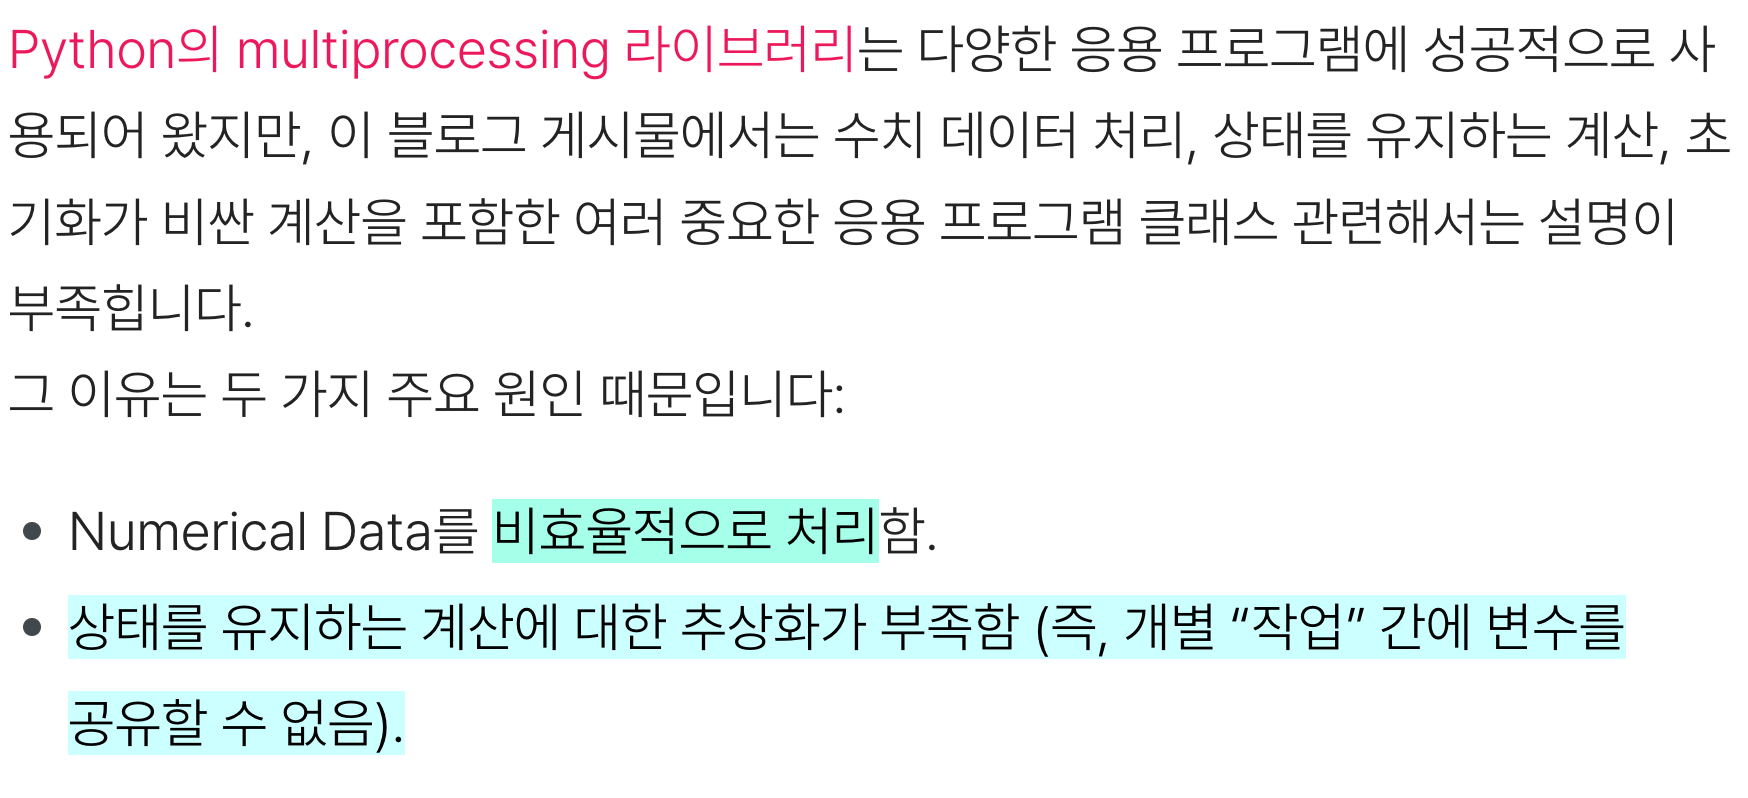
https://modulabs.co.kr/blog/ray-multiprocessing-python/

- Ray를 사용하여 빠르고 간단한 분산 응용 프로그램을 구축 가능
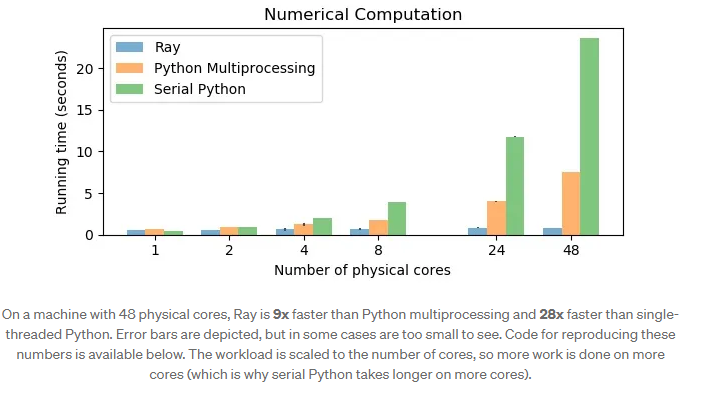
    단일 스레드보다 10-30배, multiprocessing보다 5-25배 빠르다.
    머신이 커질 경우 5-25배까지 가속된다.

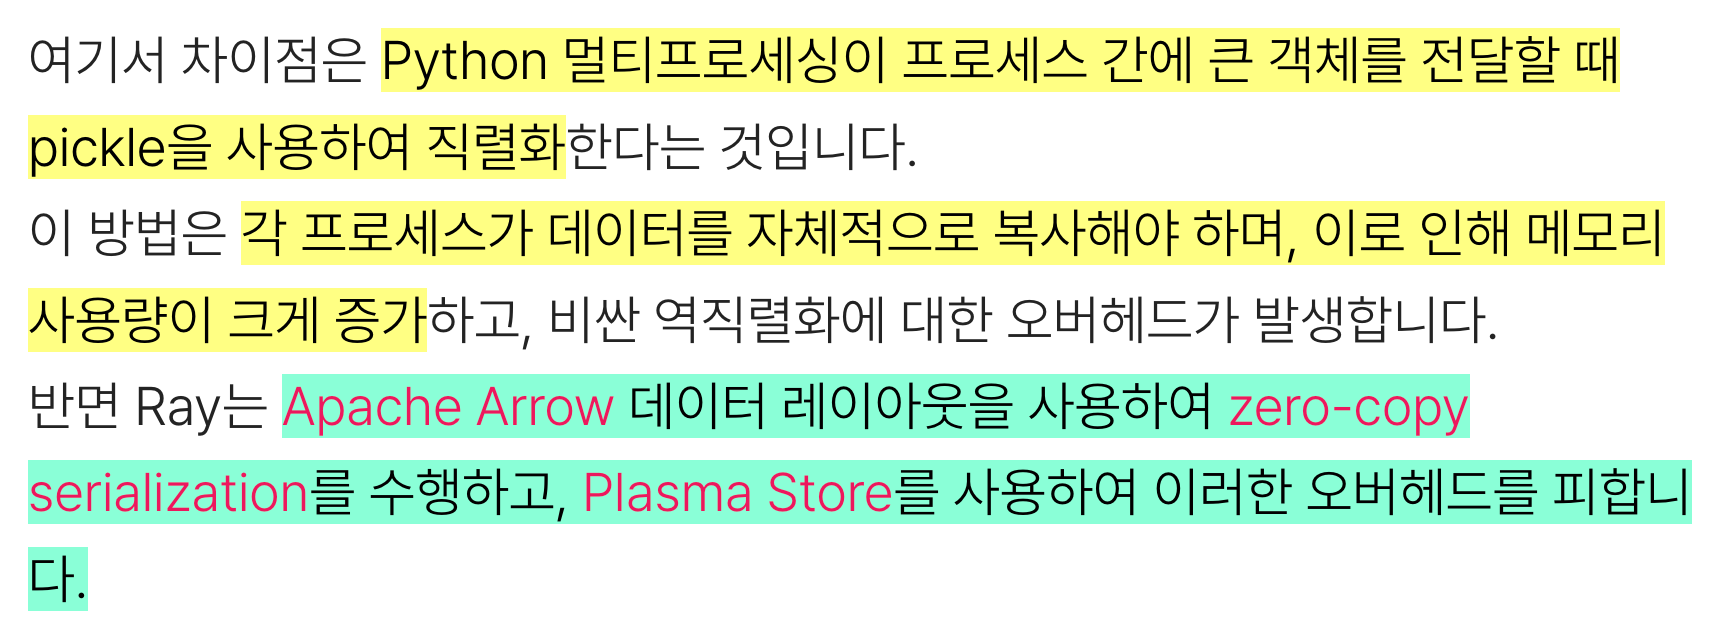
- Apache Arrow : 현대 하드웨어에서 효율적 분석 작업을 위해 설계된 언어-독립적 컬럼형 메모리 포멧, 직렬화 오버헤드 없이 빠른 데이터 액세스를 위한 zero-copy Serialization을 지원
- zero-copy Serialization : 공유 메모리에 저장되어 다중 프로세스에서 카피 없이 사용할 수 있음.
- Plasma Store : Plasma는 Apach Arrow의 일부로 인메모리 객체 저장소임. 많은 클라이언트가 효율적으로 액세스할 수 있도록 공유메모리에 불변 객체를 보관함. 여러 프레임워크 간 zero-copy 데이터 교환을 가능하게 하는 공통 데이터 레이어.

## data label로 만들기  
TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 전처리하는 방법을 학습해봅시다.

In [ ]:
# def parse_tfexample(example):
#     image_feature_description = {
#         'image/height': tf.io.FixedLenFeature([], tf.int64),
#         'image/width': tf.io.FixedLenFeature([], tf.int64),
#         'image/depth': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
#         'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
#         'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
#         'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
#         'image/encoded': tf.io.FixedLenFeature([], tf.string),
#         'image/filename': tf.io.FixedLenFeature([], tf.string),
#     }
#     return tf.io.parse_single_example(example, image_feature_description)

# print('슝=3')

In [ ]:
# # 적당한 정사각형으로 crop하여 사용하는 함수
# def crop_roi(image, features, margin=0.2):
#     img_shape = tf.shape(image)
#     img_height = img_shape[0]
#     img_width = img_shape[1]
#     img_depth = img_shape[2]

#     keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
#     keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
#     center_x = features['image/object/center/x']
#     center_y = features['image/object/center/y']
#     body_height = features['image/object/scale'] * 200.0

#     # keypoint 중 유효한값(visible = 1) 만 사용합니다.
#     masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
#     masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

#     # min, max 값을 찾습니다.
#     keypoint_xmin = tf.reduce_min(masked_keypoint_x)
#     keypoint_xmax = tf.reduce_max(masked_keypoint_x)
#     keypoint_ymin = tf.reduce_min(masked_keypoint_y)
#     keypoint_ymax = tf.reduce_max(masked_keypoint_y)

#     # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
#     xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
#     xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
#     ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
#     ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

#     # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
#     effective_xmin = xmin if xmin > 0 else 0
#     effective_ymin = ymin if ymin > 0 else 0
#     effective_xmax = xmax if xmax < img_width else img_width
#     effective_ymax = ymax if ymax < img_height else img_height
#     effective_height = effective_ymax - effective_ymin
#     effective_width = effective_xmax - effective_xmin

#     image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
#     new_shape = tf.shape(image)
#     new_height = new_shape[0]
#     new_width = new_shape[1]

#     effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
#     effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

#     return image, effective_keypoint_x, effective_keypoint_y

# print('슝=3')

In [ ]:
# # 가우시안 생성
# def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
#     heatmap = tf.zeros((height, width))

#     xmin = x0 - 3 * sigma
#     ymin = y0 - 3 * sigma
#     xmax = x0 + 3 * sigma
#     ymax = y0 + 3 * sigma
    
#     if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
#         return heatmap

#     size = 6 * sigma + 1
#     x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

#     center_x = size // 2
#     center_y = size // 2

#     gaussian_patch = tf.cast(tf.math.exp(
#         -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
#                              dtype=tf.float32)

#     patch_xmin = tf.math.maximum(0, -xmin)
#     patch_ymin = tf.math.maximum(0, -ymin)
#     patch_xmax = tf.math.minimum(xmax, width) - xmin
#     patch_ymax = tf.math.minimum(ymax, height) - ymin

#     heatmap_xmin = tf.math.maximum(0, xmin)
#     heatmap_ymin = tf.math.maximum(0, ymin)
#     heatmap_xmax = tf.math.minimum(xmax, width)
#     heatmap_ymax = tf.math.minimum(ymax, height)

#     indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
#     updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

#     count = 0

#     for j in tf.range(patch_ymin, patch_ymax):
#         for i in tf.range(patch_xmin, patch_xmax):
#             indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
#             updates = updates.write(count, gaussian_patch[j][i])
#             count += 1

#     heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

#     return heatmap

In [ ]:
# # 히트맵 생성
# def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
#     v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
#     x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
#     y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

#     num_heatmap = heatmap_shape[2]
#     heatmap_array = tf.TensorArray(tf.float32, 16)

#     for i in range(num_heatmap):
#         gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
#         heatmap_array = heatmap_array.write(i, gaussian)

#     heatmaps = heatmap_array.stack()
#     heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

#     return heatmaps

# print('슝=3')

In [14]:
# 전처리 클래스 객체의 형태로 조합
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3
(build_single_tfrecord pid=184) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0015_of_0064.tfrecords
(build_single_tfrecord pid=184) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0018_of_0064.tfrecords


## 모델을 학습해보자  
Hourglass 모델의 구조를 복습하고, 모델을 직접 구현해봅니다.

## Hourglass model만들기
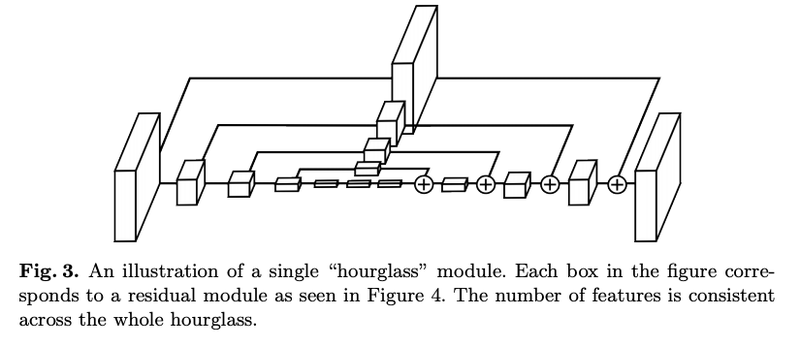

- Residual block의 2가지 타임
1. 3x3 - 3x3 basic block
2. 1x1 - 3x3 - 1x1 bottleneck block

In [15]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [16]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [17]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


In [18]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

(build_single_tfrecord pid=182) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0016_of_0064.tfrecords
(build_single_tfrecord pid=182) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0019_of_0064.tfrecords
슝=3


## 학습 엔진 만들기  
GPU가 여러 개이고 데이터를 병렬로 학습시키는 방법에 대해 공부해보아요.

In [19]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


### 분산전략
    MirroredStrategy : TensorFlow에서 다중 GPU 환경에서 모델을 훈련하기 위한 분산 전략

    TPUStrategy : 구글의 Tensor Processing Units(TPU)를 사용하여 모델을 훈련하기 위한 분산 전략

    MultiWorkerMirroredStrategy : 다중 워커(worker) 환경에서 모델을 훈련하기 위한 분산 전략

    ParameterServerStrategy : 다중 서버(server) 환경에서 모델을 훈련하기 위한 분산 전략

    CentralStorageStrategy : 중앙 저장소를 사용하여 모델을 훈련하기 위한 분산 전략

In [20]:
# 데이터셋 만드는 함수
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


In [21]:
# 
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope(): # 분산학습에서의 필요한 것
        # 분산된 데이터셋에 대한 연결 : experimental_distribute_dataset
        train_dist_dataset = strategy.experimental_distribute_dataset( 
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


In [22]:
%%time
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

# Constants for hyperparameters
epochs = 1
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

(build_single_tfrecord pid=183) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0017_of_0064.tfrecords
(build_single_tfrecord pid=183) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0020_of_0064.tfrecords
(build_single_tfrecord pid=184) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0018_of_0064.tfrecords
(build_single_tfrecord pid=184) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0021_of_0064.tfrecords
(build_single_tfrecord pid=182) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0019_of_0064.tfrecords
(build_single_tfrecord pid=182) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0022_of_0064.tfrecords
(build_single_tfrecord pid=183) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0020_of_0064.tfrecords
(build_single_tfrecord pid=183) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_002

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


(build_single_tfrecord pid=184) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=184) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0031_of_0064.tfrecords
(build_single_tfrecord pid=182) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=182) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0032_of_0064.tfrecords
(build_single_tfrecord pid=183) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=183) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0033_of_0064.tfrecords
(build_single_tfrecord pid=182) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0032_of_0064.tfrecords
(build_single_tfrecord pid=182) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=182) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=182) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=183) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=183) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0061_of_0064.tfrecords
(build_single_tfrecord pid=184) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=184) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0062_of_0064.tfrecords
(build_single_tfrecord pid=183) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0061_of_0064.tfrecords
(build_single_tfrecord pid=183) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

Trained batch 97 batch loss 1.79934919 epoch total loss 1.80049264
Trained batch 98 batch loss 1.67491138 epoch total loss 1.79921114
Trained batch 99 batch loss 1.52131832 epoch total loss 1.79640412
Trained batch 100 batch loss 1.45971823 epoch total loss 1.7930373
Trained batch 101 batch loss 1.51969576 epoch total loss 1.79033089
Trained batch 102 batch loss 1.70891809 epoch total loss 1.78953278
Trained batch 103 batch loss 1.61552143 epoch total loss 1.78784347
Trained batch 104 batch loss 1.54701591 epoch total loss 1.78552771
Trained batch 105 batch loss 1.51450682 epoch total loss 1.78294659
Trained batch 106 batch loss 1.64384663 epoch total loss 1.78163433
Trained batch 107 batch loss 1.5577414 epoch total loss 1.77954185
Trained batch 108 batch loss 1.55056858 epoch total loss 1.77742171
Trained batch 109 batch loss 1.67651653 epoch total loss 1.77649593
Trained batch 110 batch loss 1.52707362 epoch total loss 1.77422845
Trained batch 111 batch loss 1.70878339 epoch total l

Trained batch 219 batch loss 1.70328391 epoch total loss 1.71121085
Trained batch 220 batch loss 1.73293388 epoch total loss 1.71130967
Trained batch 221 batch loss 1.74137306 epoch total loss 1.71144569
Trained batch 222 batch loss 1.75519538 epoch total loss 1.71164274
Trained batch 223 batch loss 1.7721982 epoch total loss 1.71191418
Trained batch 224 batch loss 1.665941 epoch total loss 1.71170902
Trained batch 225 batch loss 1.5597403 epoch total loss 1.7110337
Trained batch 226 batch loss 1.59579706 epoch total loss 1.71052372
Trained batch 227 batch loss 1.68413818 epoch total loss 1.7104075
Trained batch 228 batch loss 1.62934911 epoch total loss 1.71005213
Trained batch 229 batch loss 1.60874796 epoch total loss 1.70960963
Trained batch 230 batch loss 1.72067308 epoch total loss 1.70965779
Trained batch 231 batch loss 1.64017868 epoch total loss 1.7093569
Trained batch 232 batch loss 1.62006092 epoch total loss 1.70897198
Trained batch 233 batch loss 1.59443569 epoch total los

Trained batch 341 batch loss 1.47071683 epoch total loss 1.67822933
Trained batch 342 batch loss 1.57487357 epoch total loss 1.67792714
Trained batch 343 batch loss 1.62385106 epoch total loss 1.67776942
Trained batch 344 batch loss 1.6203202 epoch total loss 1.67760241
Trained batch 345 batch loss 1.61820567 epoch total loss 1.67743027
Trained batch 346 batch loss 1.5686357 epoch total loss 1.67711592
Trained batch 347 batch loss 1.6096344 epoch total loss 1.67692137
Trained batch 348 batch loss 1.61857057 epoch total loss 1.67675376
Trained batch 349 batch loss 1.53750539 epoch total loss 1.67635465
Trained batch 350 batch loss 1.54377723 epoch total loss 1.67597592
Trained batch 351 batch loss 1.59874463 epoch total loss 1.67575586
Trained batch 352 batch loss 1.6222769 epoch total loss 1.67560387
Trained batch 353 batch loss 1.59364724 epoch total loss 1.67537165
Trained batch 354 batch loss 1.54110742 epoch total loss 1.67499244
Trained batch 355 batch loss 1.6570642 epoch total l

Trained batch 463 batch loss 1.51693988 epoch total loss 1.65966022
Trained batch 464 batch loss 1.50206256 epoch total loss 1.65932059
Trained batch 465 batch loss 1.3104527 epoch total loss 1.65857029
Trained batch 466 batch loss 1.44187367 epoch total loss 1.65810525
Trained batch 467 batch loss 1.52601385 epoch total loss 1.65782237
Trained batch 468 batch loss 1.35270131 epoch total loss 1.65717053
Trained batch 469 batch loss 1.26215076 epoch total loss 1.6563282
Trained batch 470 batch loss 1.32949722 epoch total loss 1.65563273
Trained batch 471 batch loss 1.39735079 epoch total loss 1.65508437
Trained batch 472 batch loss 1.50851631 epoch total loss 1.65477395
Trained batch 473 batch loss 1.52555776 epoch total loss 1.65450072
Trained batch 474 batch loss 1.64343429 epoch total loss 1.65447736
Trained batch 475 batch loss 1.63745403 epoch total loss 1.6544416
Trained batch 476 batch loss 1.64995682 epoch total loss 1.65443218
Trained batch 477 batch loss 1.62464511 epoch total

Trained batch 585 batch loss 1.34587061 epoch total loss 1.6296804
Trained batch 586 batch loss 1.53729367 epoch total loss 1.6295228
Trained batch 587 batch loss 1.52269 epoch total loss 1.62934077
Trained batch 588 batch loss 1.51498461 epoch total loss 1.62914634
Trained batch 589 batch loss 1.55827487 epoch total loss 1.62902606
Trained batch 590 batch loss 1.59716165 epoch total loss 1.62897205
Trained batch 591 batch loss 1.6034652 epoch total loss 1.6289289
Trained batch 592 batch loss 1.59076977 epoch total loss 1.62886441
Trained batch 593 batch loss 1.40230227 epoch total loss 1.62848234
Trained batch 594 batch loss 1.63081241 epoch total loss 1.62848616
Trained batch 595 batch loss 1.6160388 epoch total loss 1.62846529
Trained batch 596 batch loss 1.54931 epoch total loss 1.6283325
Trained batch 597 batch loss 1.46179199 epoch total loss 1.62805355
Trained batch 598 batch loss 1.51611745 epoch total loss 1.62786627
Trained batch 599 batch loss 1.41407239 epoch total loss 1.6

Trained batch 707 batch loss 1.59046483 epoch total loss 1.61591363
Trained batch 708 batch loss 1.50684834 epoch total loss 1.61575961
Trained batch 709 batch loss 1.54250968 epoch total loss 1.61565626
Trained batch 710 batch loss 1.55739427 epoch total loss 1.61557412
Trained batch 711 batch loss 1.50396967 epoch total loss 1.61541724
Trained batch 712 batch loss 1.46245718 epoch total loss 1.61520231
Trained batch 713 batch loss 1.48442054 epoch total loss 1.61501884
Trained batch 714 batch loss 1.47908056 epoch total loss 1.61482847
Trained batch 715 batch loss 1.5149107 epoch total loss 1.61468875
Trained batch 716 batch loss 1.55103695 epoch total loss 1.61459982
Trained batch 717 batch loss 1.56285429 epoch total loss 1.6145277
Trained batch 718 batch loss 1.55318236 epoch total loss 1.61444223
Trained batch 719 batch loss 1.58758509 epoch total loss 1.6144048
Trained batch 720 batch loss 1.57957077 epoch total loss 1.61435652
Trained batch 721 batch loss 1.51039517 epoch total

Trained batch 828 batch loss 1.26431978 epoch total loss 1.599859
Trained batch 829 batch loss 1.44476724 epoch total loss 1.59967196
Trained batch 830 batch loss 1.63005412 epoch total loss 1.59970856
Trained batch 831 batch loss 1.46735394 epoch total loss 1.59954929
Trained batch 832 batch loss 1.53276014 epoch total loss 1.59946895
Trained batch 833 batch loss 1.49965048 epoch total loss 1.59934914
Trained batch 834 batch loss 1.50382924 epoch total loss 1.59923458
Trained batch 835 batch loss 1.54292464 epoch total loss 1.59916711
Trained batch 836 batch loss 1.44429564 epoch total loss 1.59898198
Trained batch 837 batch loss 1.31067371 epoch total loss 1.59863746
Trained batch 838 batch loss 1.50697827 epoch total loss 1.59852803
Trained batch 839 batch loss 1.50900924 epoch total loss 1.59842145
Trained batch 840 batch loss 1.42894793 epoch total loss 1.59821963
Trained batch 841 batch loss 1.50254071 epoch total loss 1.59810591
Trained batch 842 batch loss 1.5200758 epoch total

Trained batch 950 batch loss 1.53801417 epoch total loss 1.58532941
Trained batch 951 batch loss 1.45922709 epoch total loss 1.58519685
Trained batch 952 batch loss 1.5271529 epoch total loss 1.58513582
Trained batch 953 batch loss 1.53870928 epoch total loss 1.58508706
Trained batch 954 batch loss 1.55977345 epoch total loss 1.5850606
Trained batch 955 batch loss 1.41151941 epoch total loss 1.58487892
Trained batch 956 batch loss 1.48801947 epoch total loss 1.58477759
Trained batch 957 batch loss 1.50034475 epoch total loss 1.58468938
Trained batch 958 batch loss 1.40874064 epoch total loss 1.58450568
Trained batch 959 batch loss 1.37346911 epoch total loss 1.5842855
Trained batch 960 batch loss 1.44906723 epoch total loss 1.58414471
Trained batch 961 batch loss 1.46220994 epoch total loss 1.58401775
Trained batch 962 batch loss 1.51345444 epoch total loss 1.58394444
Trained batch 963 batch loss 1.53612483 epoch total loss 1.58389473
Trained batch 964 batch loss 1.31618845 epoch total

Trained batch 1071 batch loss 1.42888069 epoch total loss 1.5725832
Trained batch 1072 batch loss 1.43137527 epoch total loss 1.57245147
Trained batch 1073 batch loss 1.43012273 epoch total loss 1.57231891
Trained batch 1074 batch loss 1.35758352 epoch total loss 1.57211888
Trained batch 1075 batch loss 1.43972182 epoch total loss 1.57199574
Trained batch 1076 batch loss 1.36472285 epoch total loss 1.57180309
Trained batch 1077 batch loss 1.38307548 epoch total loss 1.57162786
Trained batch 1078 batch loss 1.46952963 epoch total loss 1.57153308
Trained batch 1079 batch loss 1.47124517 epoch total loss 1.5714401
Trained batch 1080 batch loss 1.55829608 epoch total loss 1.57142794
Trained batch 1081 batch loss 1.60017717 epoch total loss 1.57145464
Trained batch 1082 batch loss 1.65336442 epoch total loss 1.57153022
Trained batch 1083 batch loss 1.50531793 epoch total loss 1.57146919
Trained batch 1084 batch loss 1.45145094 epoch total loss 1.57135844
Trained batch 1085 batch loss 1.4391

Trained batch 1191 batch loss 1.39728522 epoch total loss 1.5608983
Trained batch 1192 batch loss 1.38826549 epoch total loss 1.56075358
Trained batch 1193 batch loss 1.2902056 epoch total loss 1.56052673
Trained batch 1194 batch loss 1.46116865 epoch total loss 1.56044352
Trained batch 1195 batch loss 1.42333078 epoch total loss 1.56032884
Trained batch 1196 batch loss 1.55738795 epoch total loss 1.56032634
Trained batch 1197 batch loss 1.42449176 epoch total loss 1.56021273
Trained batch 1198 batch loss 1.40646172 epoch total loss 1.56008446
Trained batch 1199 batch loss 1.50572133 epoch total loss 1.56003916
Trained batch 1200 batch loss 1.39421988 epoch total loss 1.55990088
Trained batch 1201 batch loss 1.39574814 epoch total loss 1.55976427
Trained batch 1202 batch loss 1.49694204 epoch total loss 1.55971193
Trained batch 1203 batch loss 1.42500722 epoch total loss 1.5596
Trained batch 1204 batch loss 1.40368009 epoch total loss 1.55947053
Trained batch 1205 batch loss 1.52430665

Trained batch 1311 batch loss 1.29920828 epoch total loss 1.54953861
Trained batch 1312 batch loss 1.47078824 epoch total loss 1.54947865
Trained batch 1313 batch loss 1.44490314 epoch total loss 1.54939902
Trained batch 1314 batch loss 1.41280663 epoch total loss 1.54929519
Trained batch 1315 batch loss 1.35133541 epoch total loss 1.54914463
Trained batch 1316 batch loss 1.44937205 epoch total loss 1.54906869
Trained batch 1317 batch loss 1.34319401 epoch total loss 1.54891241
Trained batch 1318 batch loss 1.57971025 epoch total loss 1.54893577
Trained batch 1319 batch loss 1.4354502 epoch total loss 1.5488497
Trained batch 1320 batch loss 1.50799358 epoch total loss 1.54881871
Trained batch 1321 batch loss 1.36440849 epoch total loss 1.54867911
Trained batch 1322 batch loss 1.52783215 epoch total loss 1.54866326
Trained batch 1323 batch loss 1.36542678 epoch total loss 1.54852474
Trained batch 1324 batch loss 1.36534071 epoch total loss 1.54838634
Trained batch 1325 batch loss 1.4329

Validated batch 70 batch loss 1.40472722
Validated batch 71 batch loss 1.46717107
Validated batch 72 batch loss 1.31417918
Validated batch 73 batch loss 1.42994297
Validated batch 74 batch loss 1.41852975
Validated batch 75 batch loss 1.40744376
Validated batch 76 batch loss 1.46537495
Validated batch 77 batch loss 1.51824486
Validated batch 78 batch loss 1.45437372
Validated batch 79 batch loss 1.46596956
Validated batch 80 batch loss 1.51491678
Validated batch 81 batch loss 1.4366715
Validated batch 82 batch loss 1.39250624
Validated batch 83 batch loss 1.49603176
Validated batch 84 batch loss 1.42935109
Validated batch 85 batch loss 1.45331728
Validated batch 86 batch loss 1.57615328
Validated batch 87 batch loss 1.26230121
Validated batch 88 batch loss 1.39754391
Validated batch 89 batch loss 1.34331155
Validated batch 90 batch loss 1.36900043
Validated batch 91 batch loss 1.55899274
Validated batch 92 batch loss 1.32804251
Validated batch 93 batch loss 1.32043135
Validated batch 9

OSError: Unable to create file (unable to open file: name = '/aiffel/aiffel/mpii/models/model-epoch-1-loss-1.4168.h5', errno = 30, error message = 'Read-only file system', flags = 13, o_flags = 242)

In [ ]:
best_model_file # 파일이 생성되지 않았음

> 도커에서 받아오는 소프트카피 링크 경로에 권한이 없어서 에러가 뜬 것 같다. 1epoch만 테스트로 돌려보기를 잘했다.

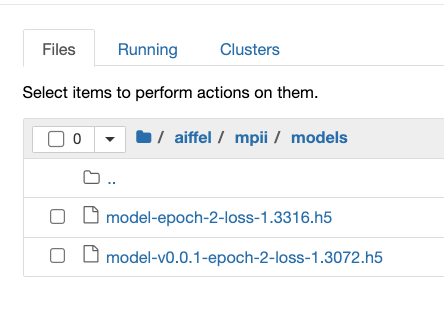
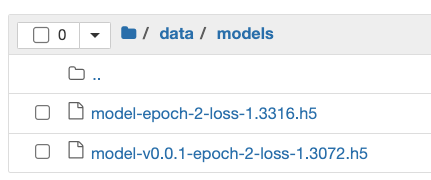
> `my_models` 경로 새로 만들고 진행
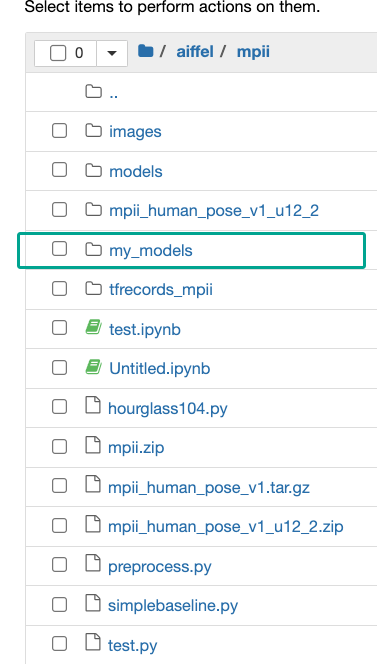

In [ ]:
%%time
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

# Constants for hyperparameters
epochs = 1
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 2.53670669 epoch total loss 2.53670669
Trained batch 2 batch loss 2.17828918 epoch total loss 2.35749793
Trained batch 3 batch loss 2.2734642 epoch total loss 2.32948661
Trained batch 4 batch loss 2.09404254 epoch total loss 2.27062559
Trained batch 5 batch loss 2.10968018 epoch total loss 2.23843646
Trained batch 6 batch loss 2.16225052 epoch total loss 2.22573876
Trained batch 7 batch loss 2.32934332 epoch total loss 2.24053955
Trained batch 8 batch loss 2.26251 epoch total loss 2.24328589
Trained batch 9 batch loss 2.24085236 epoch total loss 2.24301553
Trained batch 10 batch loss 2.22885 epoch total loss 2.24159884
Trained batch 11 batch loss 2.14574814 epoch total loss 2.23288512
Trained batch 12 batch loss 2.16746807 epoch total loss 2.22743392
Trained batch 13 batc

Trained batch 121 batch loss 1.67870009 epoch total loss 1.80905366
Trained batch 122 batch loss 1.70785785 epoch total loss 1.8082242
Trained batch 123 batch loss 1.76517534 epoch total loss 1.8078742
Trained batch 124 batch loss 1.69693518 epoch total loss 1.80697954
Trained batch 125 batch loss 1.55763936 epoch total loss 1.80498469
Trained batch 126 batch loss 1.6849041 epoch total loss 1.80403173
Trained batch 127 batch loss 1.6243335 epoch total loss 1.80261672
Trained batch 128 batch loss 1.58051217 epoch total loss 1.80088151
Trained batch 129 batch loss 1.48361492 epoch total loss 1.7984221
Trained batch 130 batch loss 1.58738756 epoch total loss 1.79679871
Trained batch 131 batch loss 1.65207326 epoch total loss 1.79569387
Trained batch 132 batch loss 1.74167109 epoch total loss 1.79528463
Trained batch 133 batch loss 1.60284138 epoch total loss 1.79383767
Trained batch 134 batch loss 1.64061713 epoch total loss 1.79269421
Trained batch 135 batch loss 1.69503224 epoch total l

Trained batch 242 batch loss 1.71051717 epoch total loss 1.71688426
Trained batch 243 batch loss 1.48774862 epoch total loss 1.71594143
Trained batch 244 batch loss 1.49888921 epoch total loss 1.71505189
Trained batch 245 batch loss 1.55405581 epoch total loss 1.71439469
Trained batch 246 batch loss 1.67488337 epoch total loss 1.71423411
Trained batch 247 batch loss 1.67573 epoch total loss 1.71407819
Trained batch 248 batch loss 1.62476921 epoch total loss 1.71371806
Trained batch 249 batch loss 1.59913301 epoch total loss 1.71325779
Trained batch 250 batch loss 1.57902288 epoch total loss 1.71272087
Trained batch 251 batch loss 1.54679227 epoch total loss 1.71205974
Trained batch 252 batch loss 1.5006659 epoch total loss 1.71122086
Trained batch 253 batch loss 1.55261898 epoch total loss 1.71059394
Trained batch 254 batch loss 1.66297424 epoch total loss 1.71040642
Trained batch 255 batch loss 1.63972569 epoch total loss 1.71012938
Trained batch 256 batch loss 1.72576678 epoch total 

- 처음에 TFRecord를 생성하는데에 시간이 소요
- Train batch 1388, Validation batch 185 만큼이 소요.

## 둠칫둠칫 댄스타임  
학습이 끝난 모델의 inference 파이프라인을 구축해봅시다.

In [ ]:
# keypoint 상수 지정
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

In [ ]:
# 좌표를 히트맵으로 바꿨음 -> 히트맵의 최댓값을 좌표로 추출하는 함수
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

In [ ]:
# 3x3 필터를 이용하여 근사치를 계산
# 256x256 -> 64x64의 heatmap max값 표현에 따른 quantization오차 발생을 줄이기 위함
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')


In [ ]:
# 모델, 이미지 입력 시 이미지와 keypoint를 출력하는 함수
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

In [ ]:
# keypoint를 그려주는 함수
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

In [ ]:
# 뼈대를 그려주는 함수
def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

In [ ]:
# 테스트 이미지를 이용하여 모델의 성능 확인하는 테스트 코드
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# Project

## 루브릭

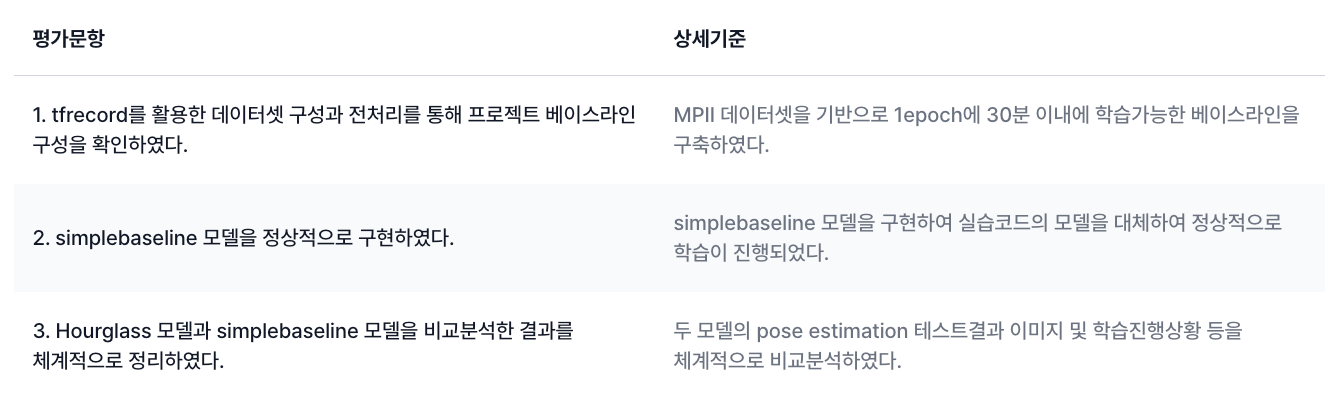

## Step 1 : simplebaseline 모델 완성하기
- simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.


### Simplebaseline 모델 생성하기
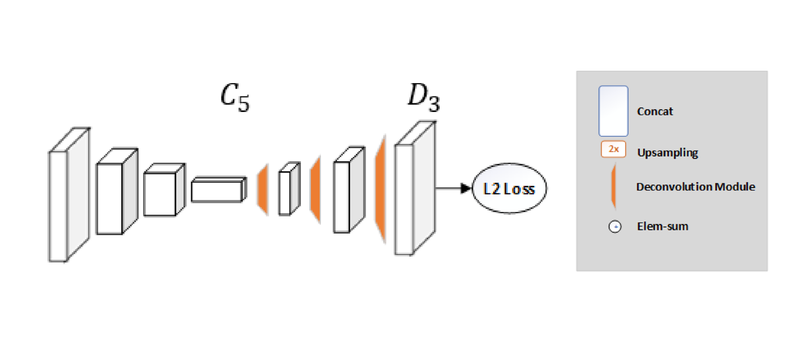

In [ ]:
import tensorflow as tf

resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()

    seq_model.add()
    

    return seq_model

upconv = _make_deconv_layer(3)

final_layer = # [[YOUR CODE]]


def Simplebaseline(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    out = 

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

## Step 2 : simplebaseline 모델로 변경하여 훈련하기
- StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

## Step 3 : 두 모델의 비교
- 실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.

### Pose Estimation 결과 시각화 (정성적 비교)


### 학습 진행 경과 (loss 감소 현황)
- 가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

# 회고